# Boostrap

All materials are taken from article (in Russian): https://habr.com/ru/companies/X5Tech/articles/679842/

Here we will consider how with use of Bootstrap we can evaluate Standard Deviation, Build Confidence Intervals and Test Hypothesis.  
We will see when Bootstrap is irreplaceable and what disadvantages it has.

# Metrics and their accuracy:

Imaging that we analyze data of deliveries from Online Shop.  
We want to understand how good our delivery is. We have data on delivery time for each order. Therefore, we can choose metric and evaluate it.  
Assume that we work with independent equally distributed random variables.

The most intuitive metric in such case - Average Time of delivery.  
To calculate Average time we can take all orders in some period of time, for example in last month and calculate average delivery time.

Assume that we calculate this metric = 90 minutes.  
In what extend we can trust this value? Obviously, it can not be True value on all future deliveries. In next month we can get different value.  
Therefore, it is important to evaluate Standard Deviation to understand how accurate is evaluation: 90+-1 minute is very different from 90+-30 minutes.

![](./pic/4.png)

where n - size of subset, Xi - random number of delivery time, $X^-$ - mean of delivery time for subset

Example Mean and SD (Standard Deviation):  
- dataset of 1000 deliveries
- distribution will be generated using Normal distribution function (in real life case distribution can be not normal):
    - mean = 90
    - standard deviation = 20

In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
import numpy as np

n = 1000
values = np.random.normal(90, 20, n)
mean = values.mean()
std = values.std() / np.sqrt(n)
print(f'Mean = {mean:0.2f}')
print(f'STD = {std:0.2f}')

Mean = 90.07
STD = 0.64


in that example, number of values was enough to make SD less than 1 minute

# Quantiles

We have evaluated Average time of delivery. It gives us some idea about current situation, but it is only one number. Some people get their deliveries fast others - slow.  
We want our clients to fill happy, therefore we want to make sure that the majority of clients get their deliveries fast enough.

We can evaluate how fast Majority of orders are delivered, for example using 90% quantile.  
What is the physical sense of quantile? If 90% quantile = 2 hours, it means that 90% of orders are delivered in 2 hours.

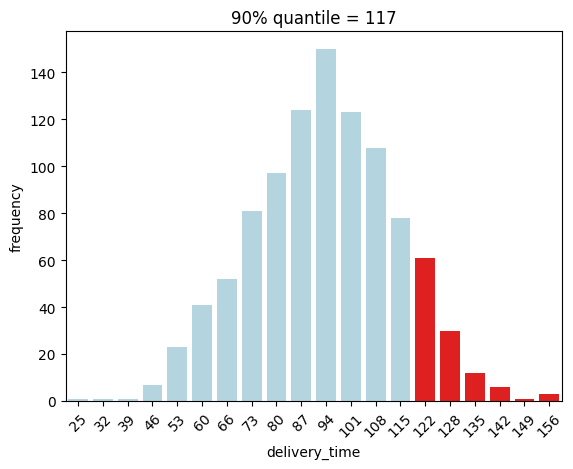

In [4]:
def interval_formating(time_group):
    time_group = str(time_group).split(',')[1].replace(' ', '').replace(']', '')
    upper_limit = round(float(time_group))
    return upper_limit

df = pd.DataFrame(values, columns=['time'])
df['time_group'] = pd.cut(df['time'], 20)
df['delivery_time'] = df['time_group'].apply(lambda x: interval_formating(x))
df_agg = df.groupby('delivery_time', as_index=False).agg(
    frequency=('time', 'count')
)
quantile_90 = round(df['time'].quantile(q=0.9))
above_or_below_quantile = ['red' if x > quantile_90 else 'lightblue' for x in df_agg['delivery_time']]

sns.barplot(data=df_agg, x='delivery_time', y='frequency', palette=above_or_below_quantile)
plt.xticks(rotation=45)
plt.title(f'90% quantile = {quantile_90}')
plt.show()

We can easily assess 90% quantile base on data, but how evaluate Standard Deviation of produced result?

It would be great if we had 100 parallel worlds from where we can get data :), we would calculate 100 different quantiles, evaluate standard deviation.

Someone can advice us to split our data of 1000 observations into 10 pieces of 100 in each. In each part we can calculate value of Quantile and evaluate Standard Deviation based on these 10 subsets.  
This approach is Missleading, since Standard Deviation depends on number of observations - the more data we have the more accurate evaluation we produce.

What we can do?  
Fortunately, there is method, which allows to evaluate Standard Deviation of some statistical value (Boostrap).

# Bootstrap

It is a method of Standard Deviation evaluation and determination of Confidence Intervals.

In the following example we will consider calculation of Standard Deviation of 90% quantile.

If we had access to the General Dataset (all deliveries in future), we could get 100 subset from there and calculate 100 Quantiles and evaluate Standard Deviation.  
We do not have Real Distribution, however, we can evaluate it based on the data available.

As an estimate of Distribution function, we will use the Empirical Distribution Function (EDF). EDF - is an unbiased estimator and converges to the tru DF as the sample size increases.

### Definition of DF and EDF

- Distribution Function (DF) of the random value X - is Function (Fx) Fx(x) = P(X < x). It is Probability that random value X will be less then x, where x - some random value
- Empirical Distribution Function (EDF) - distribution function on the subset  
EDF - is DF of discrete random value if elements of subset are independent and equally distributed. If we give weight 1/n to each element of subset, we will have EDF

Let's see how EDF looks like on dta of different size from Normal distribution:

In [5]:
from scipy import stats

def plot_ecdf(values, label, xlim):
    """build EDF graph"""
    X_ = sorted(set(values))
    Y_ = [np.mean(values <= x) for x in X_]
    X = [xlim[0]] + sum([[v, v] for v in X_], []) + [xlim[1]]
    Y = [0, 0] + sum([[v, v] for v in Y_], [])
    plt.plot(X, Y, label=label)

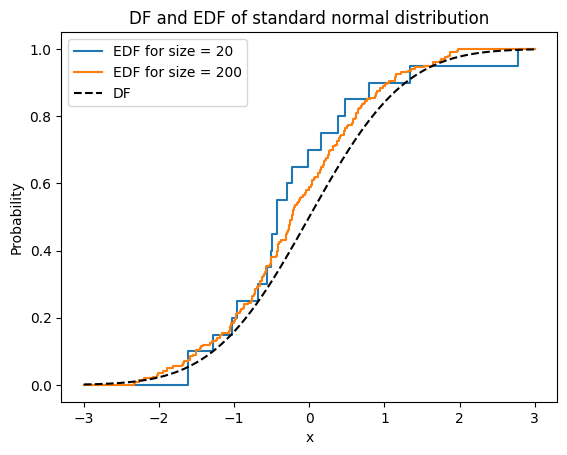

In [6]:
# generate data fir EDF:
for size in [20, 200]:
    values = np.random.normal(size=size)
    # plot EDF:
    plot_ecdf(values, f'EDF for size = {size}', [-3, 3])

# generate data for DF:
X = np.linspace(-3, 3, 1000)
Y = stats.norm.cdf(X)
# vis:
plt.plot(X, Y, '--', color='k', label='DF') # DF
plt.title('DF and EDF of standard normal distribution')
plt.xlabel('x')
plt.ylabel('Probability')
plt.legend()
plt.show()

From the graph we can see:
- with increase in size of subset, EDF is better representing DF. If we increase the size of the subset to several thousands, it will be difficult to visually distinguish EDF from DF.

Therefore, since we know that EDF is good approximation of DF we can try to get subsets from EDF. How can we do that?

Generating subset of size *n* from EDF - it the same as randomly pick *n* elements from General Dataset.  
Let's do this in code:

In [7]:
subset = np.random.choice(values, size=n, replace=True)

Now we can evaluate SD of 90% quantile evaluation. For this purpose, we will 1000 time generate subsets from EDF. Then calculate the quantile value for each subset and then evaluate Standard Deviation.

In [8]:
n = 1000 # size of the initial subset
B = 1000 # number of generations of subsets

values = np.random.normal(90, 20, n) # 90 - mean, 20 - SD
quantile = np.quantile(values, 0.9)
bootstrap_quantiles = []
for _ in range(B):
    bootstrap_values = np.random.choice(values, n, True)
    quantile_iter = np.quantile(bootstrap_values, 0.9)
    bootstrap_quantiles.append(quantile_iter)
std = np.std(bootstrap_quantiles)
print(f'90% quantile = {quantile:0.2f}')
print(f'std for 90% quantile = {std:0.2f}')

90% quantile = 115.71
std for 90% quantile = 0.93


Here we applied Bootstrap for evaluation of standard deviation of 90% quantile.

It is worth mention:
- To ensure that SD is not displaced, it is important to generate subsets of the same size as size of the initial subset
- Number of iterations for Bootstrapping is recommended in the range 1000 - 10 000. This is usually enough to get enough accurate results.

# Confidence Intervals  

Now we can evaluate SD of statistical measure. By knowing SD we can intuitively understand how reliable our evaluation is.  
For more accurate results we can build Confidence Intervals.

- Confidence Interval - covers evaluated parameter with the required probability.

probability here: if we conducted experiment many times, in average for 95% confidence interval - in 95% of experiments evaluated parameter would be inside of confidence interval

Let's come back to the example of delivery from Online Shop.   
In this example we will consider 95% of confidence interval.

If there is a big amount of data, then independently from the distribution of initial data (assuming that there is dispersion) by the Central Limit Theorem average delivery time will be distributed Normally.  
For normally distributed statistics Confidence Interval can be calculated as follows:

![](./pic/5.png)

where z1-a/2 - quantile of standard normal distribution, a - level of significance.  
for 95% confidence interval - level of significance = 0.05

![](./pic/6.png)

To build Confidence Intervals quantiles we will use Bootstrap.  
There are 3 ways to build confidence intervals using Bootstrap:

1. Similarly like we built Confidence interval for mean:
    - Evaluate quantile by initial data
    - Using Bootstrap evaluate SD for quantile
    - Calculate Confidence Interval by formula:

![](./pic/7.png)

where PE - point estimation

Such Confidence Interval is called - **"Normal Confidence Interval"**

Normal Confidence Interval is great tool for Statistics which distribution is close to Normal.

2. If distribution of statistics is not symmetrical, Normal Confidence Interval can give strange results (border of Confidence Interval is below the border of distribution).  
![](./pic/8.png)

in case of not symmetrical distributions we can use **Percentile Confidence Interval**.  
To build Percentile Confidence Interval we need to cut a/2 of distribution area from each side. For 95% CI we need to cut 2.5% from each side.

On practice to calculate CI we need to evaluate quantiles: q(a/2) and q(1-a/2) using statistics from Bootstrap.

![](./pic/9.png)

3. **Central Confidence Interval** - its borders:  
![](./pic/10.png)

![](./pic/11.png)

Centered CI for log normal distribution is moved to the size with 0 density. It can be interpreted like desire to take insurance for case if we have not full information about distribution and there can be values.

In [9]:
def get_normal_ci(bootstrap_stats, pe, alpha):
    """build normal confidence interval"""
    z = stats.norm.ppf(1 - alpha/2)
    se = np.std(bootstrap_stats)
    left = pe - z * se
    right = pe + z * se
    return left, right

def get_percentile_ci(bootstrap_stats, pe, alpha):
    """build percentile confidence interval"""
    left = np.quantile(bootstrap_stats, alpha/2)
    right = np.quantile(bootstrap_stats, 1 - alpha/2)
    return left, right

def get_pivotal_ci(bootstrap_stats, pe, alpha):
    """build pivotal confidence interval"""
    left = 2 * pe - np.quantile(bootstrap_stats, 1 - alpha/2)
    right = 2 * pe - np.quantile(bootstrap_stats, alpha/2)
    return left, right

In [10]:
n = 1000
B = 10000
alpha = 0.05
values = np.random.normal(90, 20, n)
quantile = np.quantile(values, 0.9)
bootstrap_subsets = np.random.choice(values, (B, n), True)
bootstrap_quantiles = np.quantile(bootstrap_subsets, 0.9, axis=1)

# normal confidence interval:
normal_ci = get_normal_ci(bootstrap_quantiles, quantile, alpha)
print(f'normal CI: {normal_ci}')
# percentile confidence interval:
percentile_ci = get_percentile_ci(bootstrap_quantiles, quantile, alpha)
print(f'percentile CI: {percentile_ci}')
# pivotal confidence interval:
pivotal_ci = get_pivotal_ci(bootstrap_quantiles, quantile, alpha)
print(f'pivotal CI: {pivotal_ci}')

normal CI: (113.64047840248575, 118.00509372064245)
percentile CI: (113.60848466274258, 118.09432880090867)
pivotal CI: (113.55124332221953, 118.03708746038562)


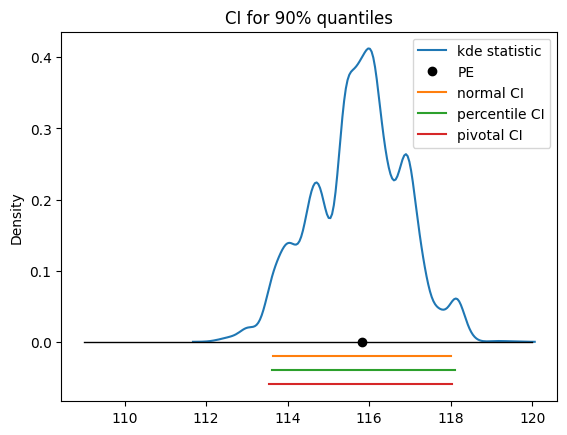

In [11]:
sns.kdeplot(bootstrap_quantiles, label='kde statistic')
plt.plot([quantile], [0], 'o', c='k', markersize=6, label='PE')
plt.plot([109, 120], [0, 0], 'k', linewidth=1) # x bottom line
d = 0.02 # margin between CI lines
# CI lines:
plt.plot(normal_ci, [-d, -d], label='normal CI')
plt.plot(percentile_ci, [-d*2, -d*2], label='percentile CI')
plt.plot(pivotal_ci, [-d*3, -d*3], label='pivotal CI')

plt.title('CI for 90% quantiles')
plt.legend()
plt.show()

# Bootstrap and A/B testing:

Now we can build Confidence Intervals.  
Using CI we can not only produce additional information about studied metrics but also Test Statistical Hypothesis.

To test hypothesis that quantiles are equal in level of importance = 5%, it is enough to build 95% confidence intercal for difference of quantiles between groups.   
If Zero is outside of the confidence interval, therefore differences statistically significant otherwise not.

t - statistical measure  
t = 0 - Null Hypothesis  
t != 0 - Alternative Hypothesis

![](./pic/12.png)

Algorithm of testing hypothesis that 2 statistics are equal (using Bootstrap):
1. Generate 2 subsets of the same size like Control and Experimental groups
2. Calculate metrics for each group
3. Calculate differences between metrics, store results
4. Repeat steps 1-3 from 1000 to 10000 times
5. Build Confidence Interval with required level of significance
6. If 0 does not belong to the confidence interval, therefore differences are statistically significant, otherwise they are not

Let's see how this algorithm can be implemented.  
Note: For experimental group we will reduce Dispersion, which will result in decrease of 90% quantile.

In [25]:
n = 1000
B = 10000
alpha = 0.05

values_a = np.random.normal(90, 20, n)
values_b = np.random.normal(90, 15, n) # experimental group with lower dispersion

pe = np.quantile(values_b, 0.9) - np.quantile(values_a, 0.9)
bootstrap_values_a = np.random.choice(values_a, (B, n), True)
bootstrap_values_b = np.random.choice(values_b, (B, n), True)
bootstrap_metrics_a = np.quantile(bootstrap_values_a, 0.9, axis=1)
bootstrap_metrics_b = np.quantile(bootstrap_values_b, 0.9, axis=1)
bootstrap_stats = bootstrap_metrics_b - bootstrap_metrics_a
ci = get_percentile_ci(bootstrap_stats, pe, alpha)
has_effect = not (ci[0] < 0 < ci[1])

print(f'90% quantile = {pe:0.2f}')
print(f'{(1 - alpha) * 100}% Confidence Interval: {ci[0]:0.2f}, {ci[1]:0.2f}')
print(f'Differences are statistically significant: {has_effect}')

90% quantile = -7.66
95.0% Confidence Interval: -10.13, -4.19
Differences are statistically significant: True


As the result we see that differences in 90% quantile in 2 groups are statistically significant.

# Bootstrap Limitations

Bootstrap is universal method. It is very useful for CI building and testing hypothesis of not trivial metrics.    
But it also has disadvantages:
- Main disadvantage - slow speed. Calculations are computationally expensive. It can be felt when amount of data is significant, then Bootstrap application can take hours and longer.

- In all previous examples we assumed that we deal with independent equally distributed random variables. In such cases for generating subsets we could simply pick random values from initial dataset. But if data are dependent and have complex nature, then for generating subsets it is important to consider this. Otherwise, evaluation of statistics distribution would badly explain Real Distribution.

- Data quality is important - if data are corrupted and not representative, therefore Bootstrap will give misleading results